<p style="text-align:center; font-size:30px; font-family:cursive;"> Welcome to PS_S3_Ep10 Challenge </p>

# Importing necessary libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, train_test_split, cross_val_predict
from sklearn.preprocessing import MinMaxScaler

import xgboost as xgb
from catboost import CatBoostClassifier
import lightgbm as lgb
import optuna
from optuna.samplers import TPESampler

import torch
import torch.nn as nn
from torch.utils.data import Dataset as Dataset
from torch.utils.data import DataLoader
import torchinfo
from tqdm import tqdm

BASIC = False # To use basic hyperparameters or not
TUNE = False # Whether to tune our hyperparameters - I suggest turning on GPU for this task

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
device

device(type='cuda')

# Data Preparation

#### As with any machine learning task, let us observe what our data looks like and what we can do with it.
#### Let's also combine the original dataset with the current training dataset, dropping duplicates in the middle of the process.

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s3e10/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e10/test.csv')
sample = pd.read_csv('/kaggle/input/playground-series-s3e10/sample_submission.csv')
original = pd.read_csv('/kaggle/input/pulsar-classification-for-class-prediction/Pulsar.csv')

total_train = pd.concat([train, original])
total_train.drop_duplicates(inplace=True)

total_train

,id,Mean_Integrated,SD,EK,Skewness,Mean_DMSNR_Curve,SD_DMSNR_Curve,EK_DMSNR_Curve,Skewness_DMSNR_Curve,Class
0,0.0,133.171875,59.716081,0.043133,-0.703383,54.917224,70.084438,0.749798,-0.649512,0
1,1.0,87.093750,36.257973,0.435469,2.266057,3.417224,21.865069,7.039330,52.686251,0
2,2.0,112.640625,39.818393,0.379639,0.922306,2.730769,15.689690,8.193471,85.649785,0
3,3.0,120.679688,45.918448,-0.098490,0.011775,2.696488,20.954662,8.183874,70.332899,0
4,4.0,134.070312,57.720107,-0.107772,-0.573335,1.107860,11.255051,16.107748,308.753765,0
...,...,...,...,...,...,...,...,...,...,...
17893,NaN,136.429688,59.847421,-0.187846,-0.738123,1.296823,12.166062,15.450260,285.931022,0
17894,NaN,122.554688,49.485605,0.127978,0.323061,16.409699,44.626893,2.945244,8.297092,0
17895,NaN,119.335938,59.935939,0.159363,-0.743025,21.430602,58.872000,2.499517,4.595173,0
17896,NaN,114.507812,53.902400,0.201161,-0.024789,1.946488,13.381731,10.007967,134.238910,0


In [3]:
features = list(total_train.columns[1:-1])
target = 'Class'

In [4]:
total_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135462 entries, 0 to 17897
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    117564 non-null  float64
 1   Mean_Integrated       135462 non-null  float64
 2   SD                    135462 non-null  float64
 3   EK                    135462 non-null  float64
 4   Skewness              135462 non-null  float64
 5   Mean_DMSNR_Curve      135462 non-null  float64
 6   SD_DMSNR_Curve        135462 non-null  float64
 7   EK_DMSNR_Curve        135462 non-null  float64
 8   Skewness_DMSNR_Curve  135462 non-null  float64
 9   Class                 135462 non-null  int64  
dtypes: float64(9), int64(1)
memory usage: 11.4 MB


#### Seems like our data has no missing values apart from the id but that is a column to be dropped so we don't need to worry about it.

# Data Visualizing

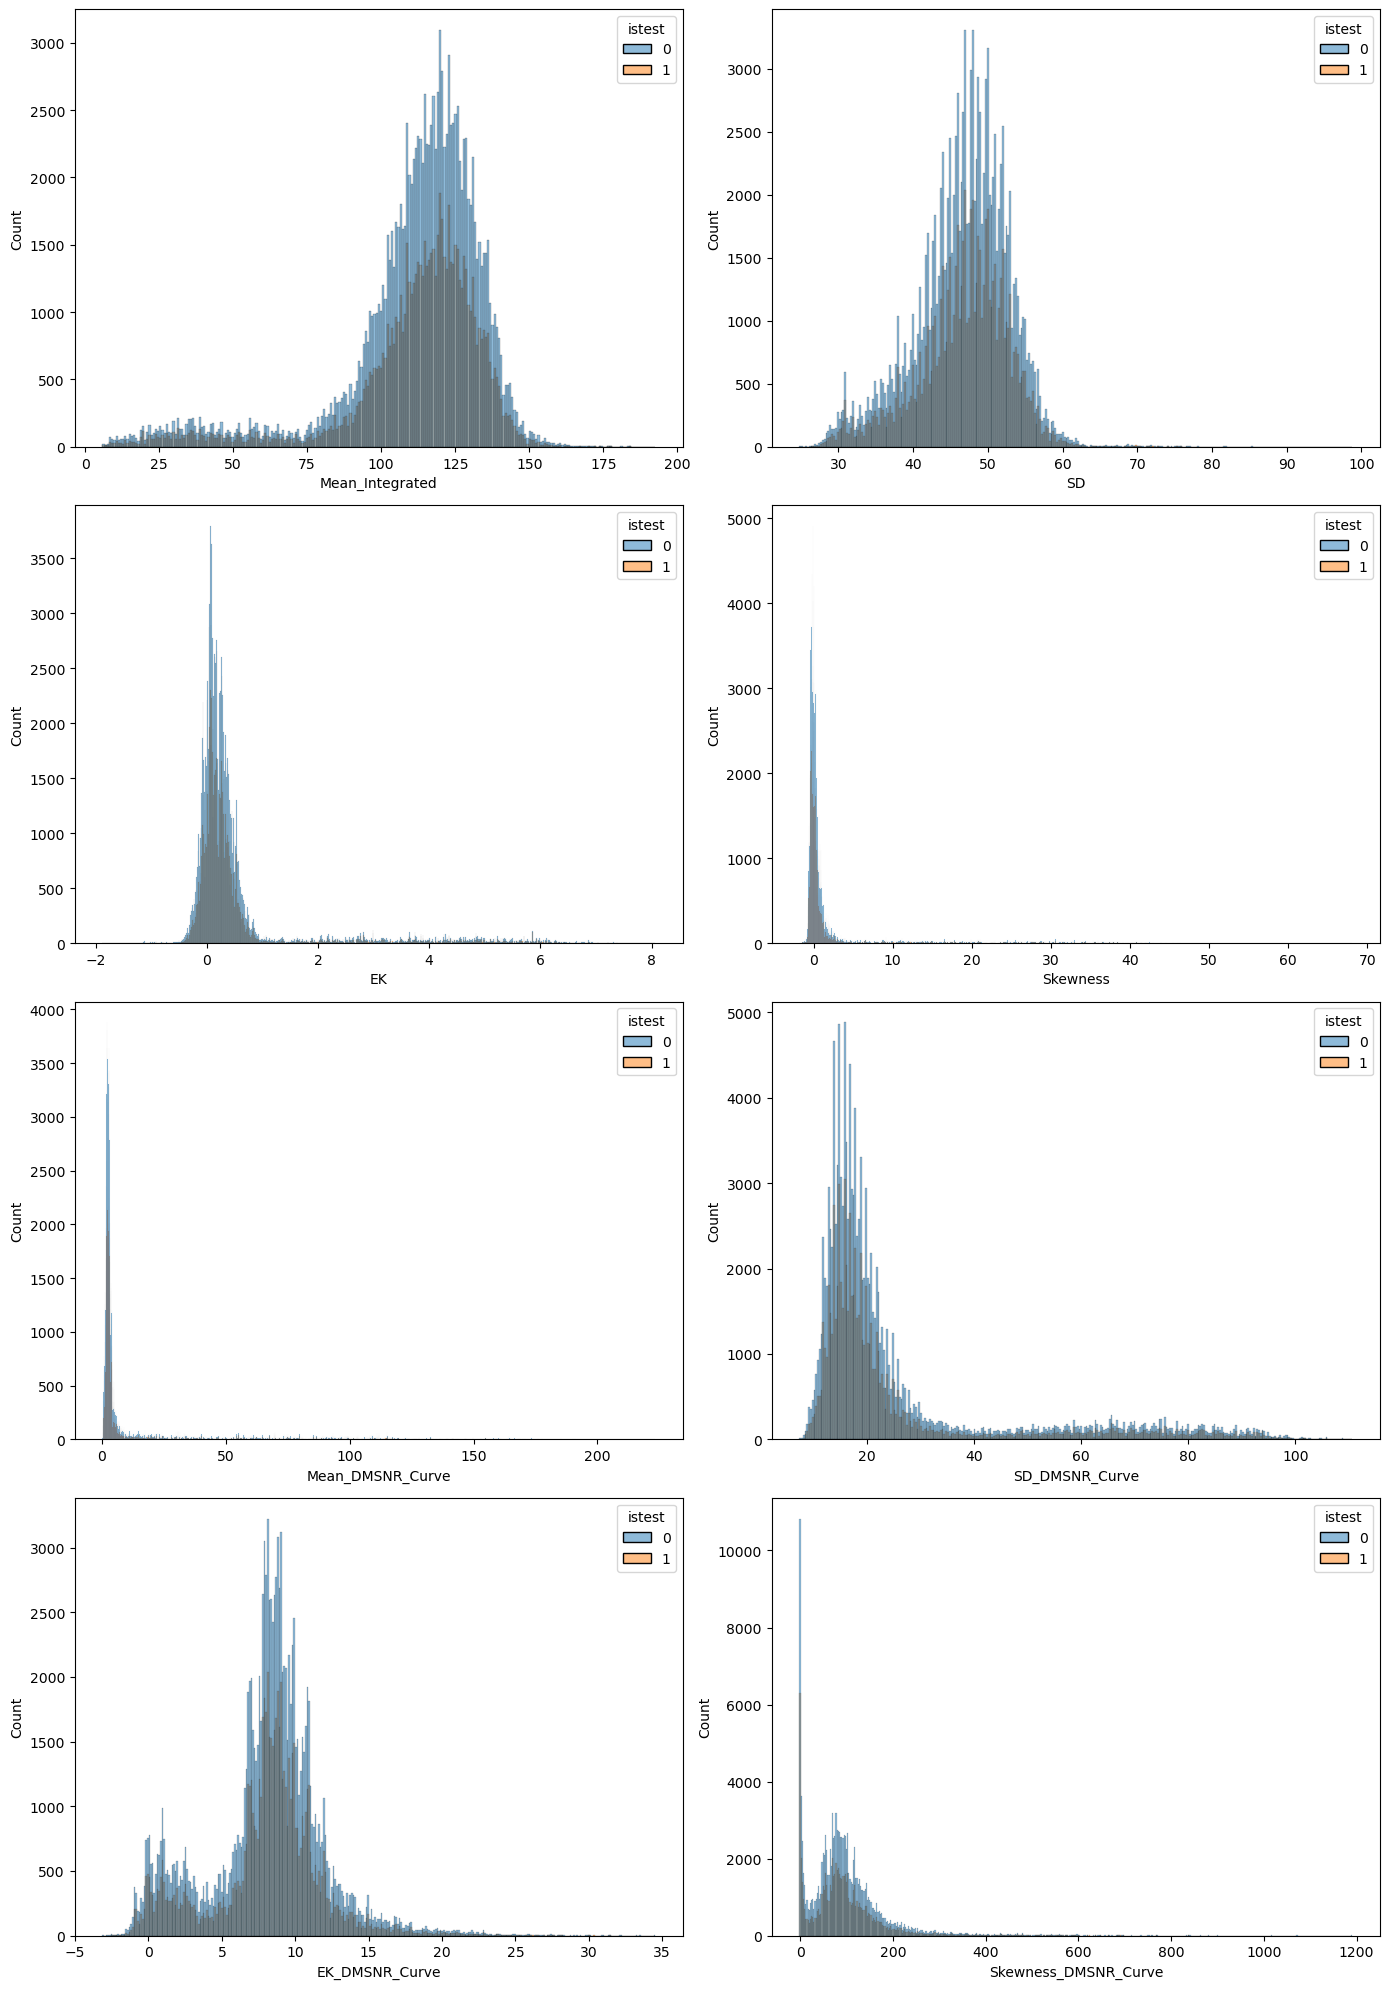

In [5]:
rows, cols = 4, 2
fig, axs = plt.subplots(rows, cols, figsize=(14,20))
total_train['istest'] = 0
test['istest'] = 1
features.extend(['istest'])
raw = pd.concat([total_train, test])
raw.reset_index(inplace=True)
for i in range(rows):
    for j in range(cols):
        sns.histplot(raw[features], x = features[i*2+j], hue='istest', ax=axs[i][j])
features.remove('istest')
plt.tight_layout()
plt.show()

#### Since I won't be utilizing any scale sensitive models, I won't bother scaling the inputs.
#### If I ever think of running any scale sensitive models, then I believe I will have to perform some scaling as it is pretty evident that the inputs are spread out over an extremely wide range which may distort our model's outputs.

#### Furthermore, they all look to be of numerical types. 
#### We won't need to deal with any categorical data types.

# Modeling

In [6]:
X = total_train[features]
y = total_train[target]

#### As with any tabular machine learning task, let us utilize the powerful XGBoost!

In [7]:
if BASIC:
    xgb_params = {
        'verbosity' : 0,
    }

else: 
    xgb_params = {'max_depth': 4, 
                  'learning_rate': 0.09611818583558296, 
                  'n_estimators': 270, 
                  'min_child_weight': 5, 
                  'gamma': 0.28475464776988313, 
                  'subsample': 0.9134512574147342, 
                  'colsample_bytree': 0.3787011404635416, 
                  'reg_alpha': 0.6415802448962679, 
                  'reg_lambda': 0.1986109971071448}
    
xgbc = xgb.XGBClassifier(**xgb_params)

print(np.mean(cross_val_score(xgbc, X, y, cv=5, scoring='neg_log_loss'))*-1)

0.037237564726278136


#### Let's see how well CatBoostRegressor does!

In [8]:
if BASIC:
    catboost_params = {
        'verbose' : False
    }
else:
    catboost_params = {'iterations': 739, 
                       'learning_rate': 0.20343252867548206, 
                       'depth': 4, 
                       'l2_leaf_reg': 36.66494999011264, 
                       'bootstrap_type': 'Bayesian', 
                       'random_strength': 42.140339799438195, 
                       'bagging_temperature': 7.250462648914117, 
                       'od_type': 'Iter', 
                       'od_wait': 37,
                       'verbose': False}

catboost = CatBoostClassifier(**catboost_params)

print(np.mean(cross_val_score(catboost, X, y, cv=5, scoring='neg_log_loss'))*-1)

0.03732287406883925


#### How about LGBMClassifier?

In [9]:
if BASIC:
    lgbm_params = {
        'verbose' : -1,
    }

else:
    lgbm_params = {'boosting_type': 'gbdt', 
                   'num_leaves': 97, 
                   'learning_rate': 0.019299497033284117, 
                   'n_estimators': 938, 
                   'max_depth': 7, 
                   'min_child_samples': 183, 
                   'subsample': 0.7510503722144701, 
                   'colsample_bytree': 0.6291255251801097, 
                   'reg_alpha': 0.40274561975696616, 
                   'reg_lambda': 0.6655461171405869}

lgbm = lgb.LGBMClassifier(**lgbm_params)

print(np.mean(cross_val_score(lgbm, X, y, cv=5, scoring='neg_log_loss'))*-1)

0.03766593418442425


#### Seems like XGBoost and CatBoost shows the most promise. 
#### Let's see whether we can tune their hyperparameters!

# Hyperparameter Tuning

## XGBoost

In [10]:
def objective(trial):   
    params_optuna = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0),
        "tree_method":"gpu_hist"
        }

    xgb_tuned = xgb.XGBClassifier(**params_optuna)
    scores = cross_val_score(xgb_tuned, X, y, 
                            cv=KFold(n_splits=10,
                            shuffle=True,
                            random_state=42),
                            scoring="neg_log_loss"
                            )
    return (scores.mean() * (-1))

if TUNE:
    xgb_tuning = optuna.create_study(direction='minimize', sampler = TPESampler())
    xgb_tuning.optimize(func=objective, n_trials=50)
    print(xgb_tuning.best_params)

## CatBoost

In [11]:
def objective(trial): 
    
    params_optuna = {
        'iterations':trial.suggest_int("iterations", 100, 1000),
        'learning_rate' : trial.suggest_float('learning_rate',0.01, 1),
        'depth':trial.suggest_int("depth", 4, 10),
        'l2_leaf_reg':trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        'bootstrap_type':trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        'random_strength': trial.suggest_float('random_strength',10,50),
        'bagging_temperature':trial.suggest_float("bagging_temperature", 0.0, 10.0),
        'od_type':trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        'od_wait':trial.suggest_int("od_wait", 10, 50),
        'verbose':False,
        'task_type' : 'GPU'
    }

    catboost_tuned = CatBoostClassifier(**params_optuna)
    scores = cross_val_score(catboost_tuned, X, y, 
                            cv=KFold(n_splits=10,
                            shuffle=True,
                            random_state=42),
                            scoring="neg_log_loss"
                            )
    return (scores.mean() * (-1))

if TUNE:
    catboost_tuning = optuna.create_study(direction='minimize', sampler = TPESampler())
    catboost_tuning.optimize(func=objective, n_trials=100)
    print(catboost_tuning.best_params)

## LGBM

In [12]:
def objective(trial): 
    
    params_optuna = {
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss']),
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 200),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 1.0),
        'device': 'gpu'
    }

    lgbm_tuned = lgb.LGBMClassifier(**params_optuna)
    scores = cross_val_score(lgbm_tuned, X, y, 
                            cv=KFold(n_splits=10,
                            shuffle=True,
                            random_state=42),
                            scoring="neg_log_loss"
                            )
    return (scores.mean() * (-1))

if TUNE:
    lgbm_tuning = optuna.create_study(direction='minimize', sampler = TPESampler())
    lgbm_tuning.optimize(func=objective, n_trials=5)
    print(lgbm_tuning.best_params)

# Ensembling and Submitting

In [13]:
xgb_params = {'max_depth': 4, 
                  'learning_rate': 0.09611818583558296, 
                  'n_estimators': 270, 
                  'min_child_weight': 5, 
                  'gamma': 0.28475464776988313, 
                  'subsample': 0.9134512574147342, 
                  'colsample_bytree': 0.3787011404635416, 
                  'reg_alpha': 0.6415802448962679, 
                  'reg_lambda': 0.1986109971071448}
    
xgbc = xgb.XGBClassifier(**xgb_params)

catboost_params = {'iterations': 739, 
                       'learning_rate': 0.20343252867548206, 
                       'depth': 4, 
                       'l2_leaf_reg': 36.66494999011264, 
                       'bootstrap_type': 'Bayesian', 
                       'random_strength': 42.140339799438195, 
                       'bagging_temperature': 7.250462648914117, 
                       'od_type': 'Iter', 
                       'od_wait': 37,
                       'verbose': False}

catboost = CatBoostClassifier(**catboost_params)

lgbm_params = {'boosting_type': 'gbdt', 
                   'num_leaves': 97, 
                   'learning_rate': 0.019299497033284117, 
                   'n_estimators': 938, 
                   'max_depth': 7, 
                   'min_child_samples': 183, 
                   'subsample': 0.7510503722144701, 
                   'colsample_bytree': 0.6291255251801097, 
                   'reg_alpha': 0.40274561975696616, 
                   'reg_lambda': 0.6655461171405869}

lgbm = lgb.LGBMClassifier(**lgbm_params)

xgbc.fit(total_train[features], total_train[target])
catboost.fit(total_train[features], total_train[target])
lgbm.fit(total_train[features], total_train[target])

LGBMClassifier(colsample_bytree=0.6291255251801097,
               learning_rate=0.019299497033284117, max_depth=7,
               min_child_samples=183, n_estimators=938, num_leaves=97,
               reg_alpha=0.40274561975696616, reg_lambda=0.6655461171405869,
               subsample=0.7510503722144701)

In [14]:
test.drop(['istest', 'id'], axis=1, inplace=True)

test = test[features]

xgb_pred = xgbc.predict_proba(test)[:, 1]
catboost_pred = catboost.predict_proba(test)[:, 1]
lgbm_pred = lgbm.predict_proba(test)[:, 1]

ensemble_pred = (xgb_pred + catboost_pred + lgbm_pred)/3
sample['Class'] = ensemble_pred
    
sample.to_csv('submission.csv', index=False)
sample.head()

,id,Class
0,117564,0.000098
1,117565,0.002565
2,117566,0.000172
3,117567,0.083382
4,117568,0.002741


# Deep Learning (Additional Exploration)

#### Usually, deep learning techniques are not utilized as much when it comes to tabular data. 
#### With deep learning tasks, we usually need a huge number of data.
#### However, I will attempt to create one deep learning model with PyTorch, just for the fun of it!

#### Let's first scale our data, both train and test datasets.

In [15]:
# total_train and test dataframes will have to be scaled using the min-max scaler 
scaler = MinMaxScaler()

total_train['istest'] = 0
test['istest'] = 1

# Let's concat them to prepare them for scaling
temp = pd.concat([total_train, test])
temp[features] = scaler.fit_transform(temp[features])

train_scaled = temp[temp['istest'] == 0]
test_scaled = temp[temp['istest'] == 1]

#### Let's visualize what our scaled data looks like now

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


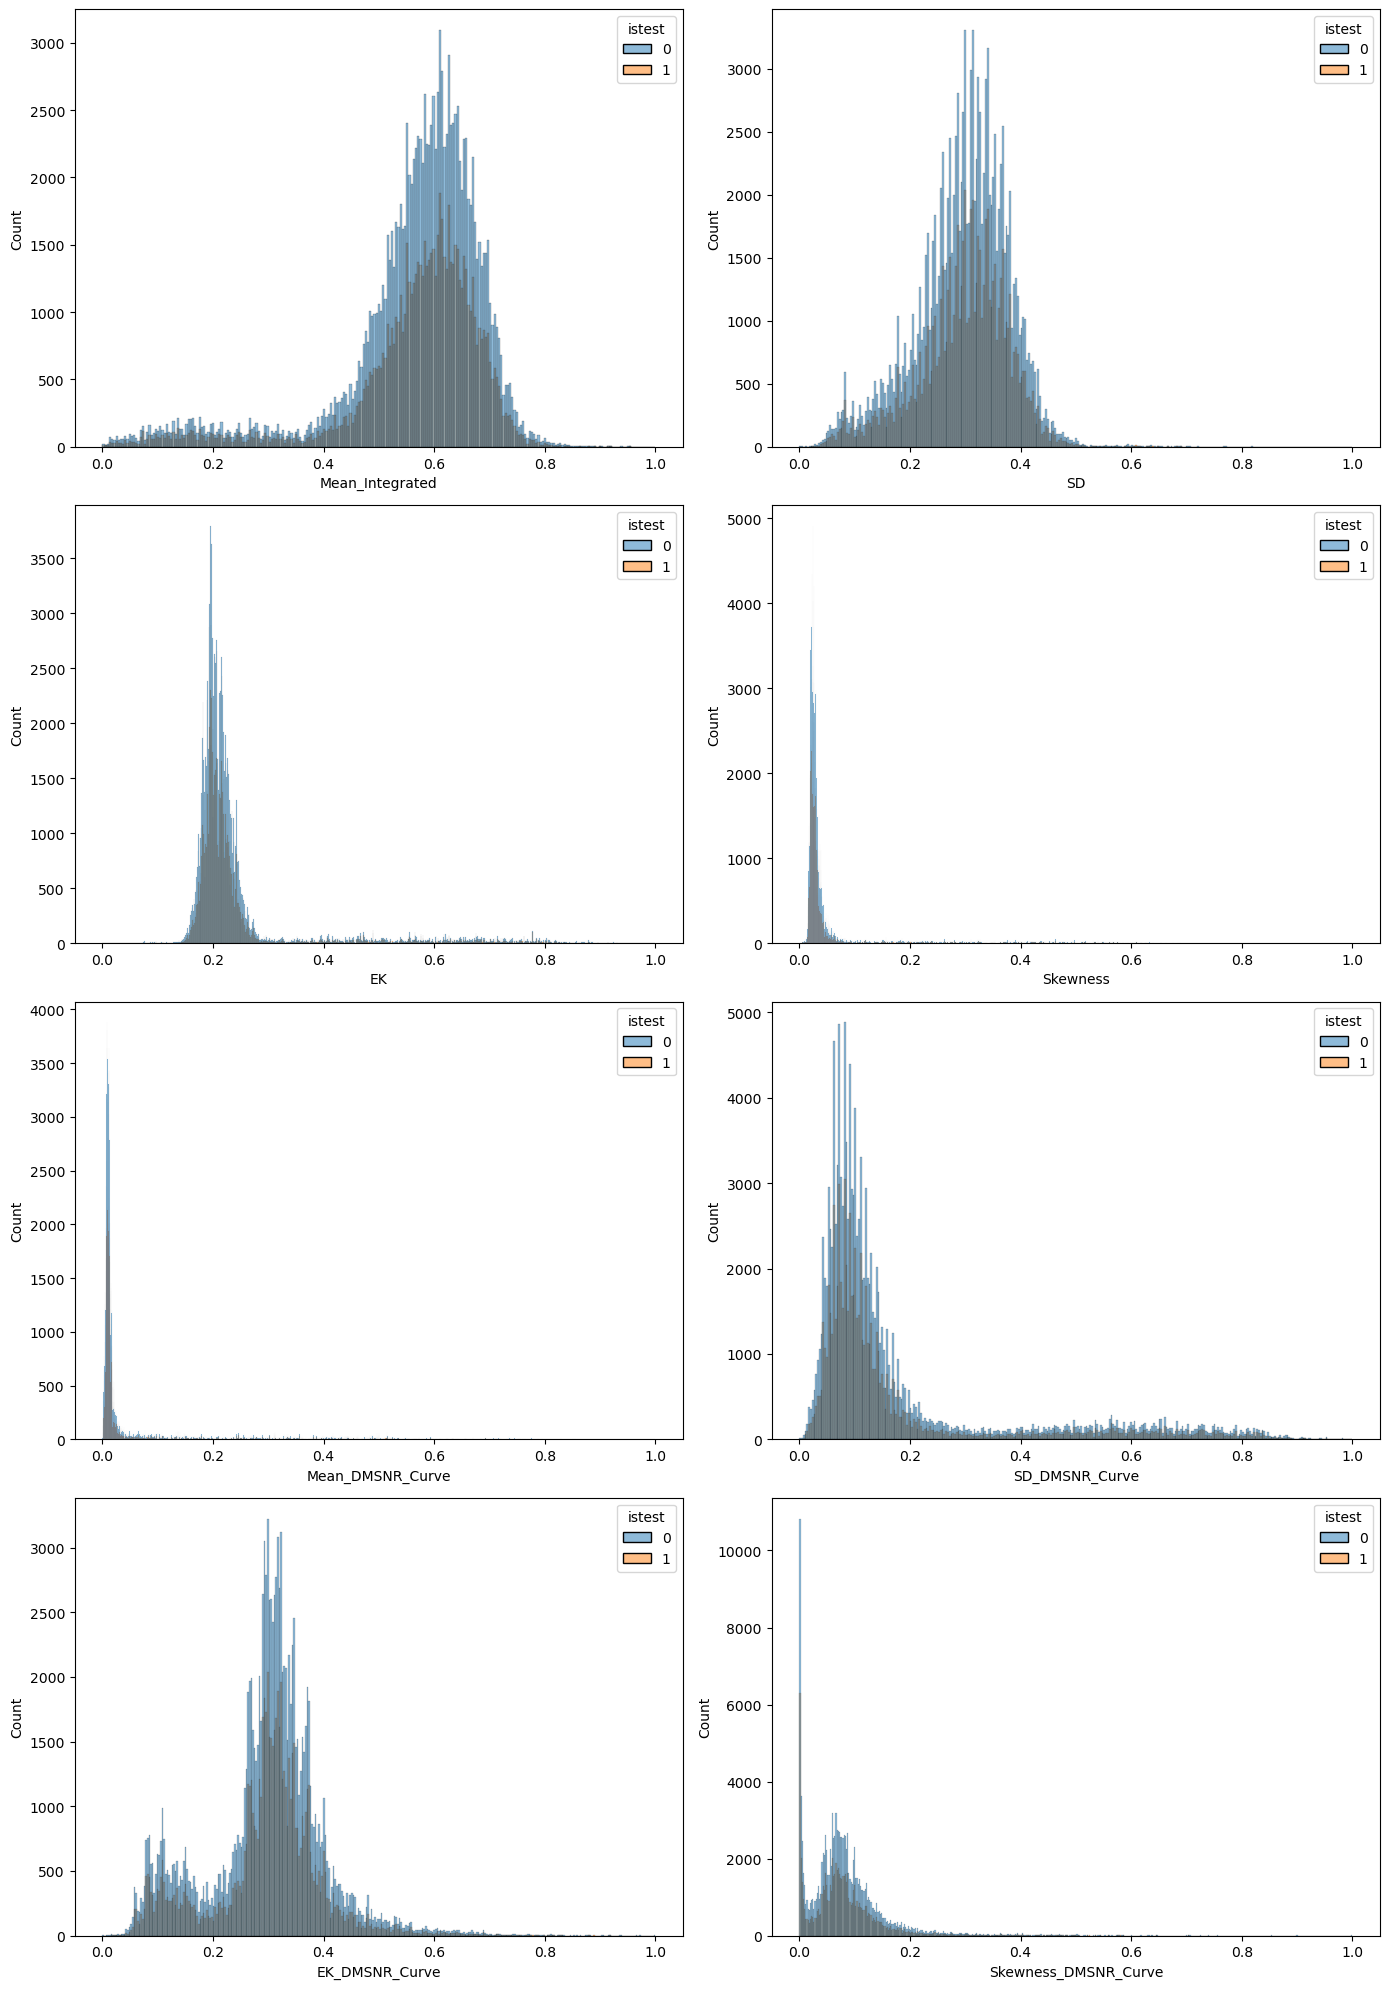

In [16]:
rows, cols = 4, 2
fig, axs = plt.subplots(rows, cols, figsize=(14,20))
train_scaled['istest'] = 0
test_scaled['istest'] = 1
features.extend(['istest'])
raw = pd.concat([train_scaled, test_scaled])
raw.reset_index(inplace=True)
for i in range(rows):
    for j in range(cols):
        sns.histplot(raw[features], x = features[i*2+j], hue='istest', ax=axs[i][j])
features.remove('istest')
plt.tight_layout()
plt.show()

#### Scaling has been done and it seems perfect so far. 
#### All the values are within the range of 0 and 1. 
#### Although, we do observe some of the features' values as being skewed. 
#### Let's first proceed on with creating a custom dataset and dataloader for our mode.

## Custom Data

In [17]:
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.df = dataframe        
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        
        X = torch.tensor(self.df[features].iloc[idx], dtype=torch.float)
        y = torch.tensor(self.df.iloc[idx, -2], dtype=torch.float)
            
        return X,y

In [18]:
train_data_custom = CustomDataset(train_scaled.iloc[:94816,:])
validation_data_custom = CustomDataset(train_scaled.iloc[-40640: , :])
test_data_custom = CustomDataset(test_scaled)

In [19]:
print(f"We have {len(train_data_custom)} training datapoints, {len(validation_data_custom)} validation datapoints, and {len(test_data_custom)} testing datapoints")

We have 94816 training datapoints, 40640 validation datapoints, and 78377 testing datapoints


In [20]:
train_dataloader_custom = DataLoader(dataset=train_data_custom, 
                                     batch_size=32,
                                     num_workers=1, 
                                     shuffle=True) 

validation_dataloader_custom = DataLoader(dataset = validation_data_custom,
                                         batch_size=32,
                                         num_workers = 1,
                                         shuffle=False)

test_dataloader_custom = DataLoader(dataset=test_data_custom, 
                                    batch_size=1, 
                                    num_workers=1, 
                                    shuffle=False)

train_dataloader_custom, validation_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7f26c1d6c890>,
 <torch.utils.data.dataloader.DataLoader at 0x7f26ca9df250>)

#### Ok, let's check if our dataloader is working correctly.

In [21]:
X, y = next(iter(train_dataloader_custom))

print(f"X shape: {X.shape} -> [batch size, number of features]")
print(f"y shape: {y.shape}")

X shape: torch.Size([32, 8]) -> [batch size, number of features]
y shape: torch.Size([32])


#### Perfect!
#### Seems like all is working as intended.
#### Now, let us see what kind of model we will be building here.

## Modeling

#### Let us create a simple linear model and a classifying layer at the end.

In [22]:
class DLModel(nn.Module):
    def __init__(self, input_shape, hidden_shape, output_shape):
        super().__init__()
        self.linear_1 = nn.Sequential(
            nn.Linear(input_shape, hidden_shape),
            nn.ReLU()
        )
        self.linear_2 = nn.Sequential(
            nn.Linear(hidden_shape, hidden_shape * 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.BatchNorm1d(hidden_shape * 2)
        )
        self.linear_3 = nn.Sequential(
            nn.Linear(hidden_shape * 2, hidden_shape),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.BatchNorm1d(hidden_shape)
        )
        self.linear_4 = nn.Sequential(
            nn.Linear(hidden_shape*2, hidden_shape*2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.BatchNorm1d(hidden_shape*2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(hidden_shape, 32),
            nn.Linear(32, output_shape),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.linear_1(x)
        x = self.linear_2(x)
        x = self.linear_4(x)
        x = self.linear_3(x)
        x = self.classifier(x)
        return x
    
model = DLModel(8, 128, 2)
model.to(device)

DLModel(
  (linear_1): Sequential(
    (0): Linear(in_features=8, out_features=128, bias=True)
    (1): ReLU()
  )
  (linear_2): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (linear_3): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (linear_4): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=128, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=2, bias=True)
    (2): Sigmoid()
  )
)

#### Our model is rather simple.
#### It utilizes the ReLU activation function and a 20% Dropout layer to discourage overfitting.

## Training

In [23]:
# Setup loss function and optimizer
lf = nn.BCELoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.005)

epochs = 50

train_loss_arr = []
test_loss_arr = []

for epoch in range(epochs):
    train_loss = 0
    
    for batch, (X,y) in enumerate(train_dataloader_custom):
        X = X.to(device)
        y = y.to(device)
        model.train()
        
        # Forward
        y_pred = model(X)
        
        # Calculate loss
        loss = lf(y_pred[:,1], y)
        train_loss += loss
        
        # Zero grad
        optimizer.zero_grad()
        
        # Loss backward
        loss.backward()
        
        # Optimizer step
        optimizer.step()
        
        """if batch%1000 == 0:
            print("-------Batch {}-------Loss: {}--------".format(batch, loss))"""
    
    train_loss/=len(train_dataloader_custom)
    train_loss_arr.append(train_loss.cpu().detach().numpy())
    
    test_loss = 0
    model.eval() 
    with torch.inference_mode():
        for batch, (X,y) in enumerate(validation_dataloader_custom):
            X = X.to(device)
            y = y.to(device)
            
            # Forward
            test_pred = model(X)
            
            # Calculate loss 
            test_loss += lf(test_pred[:,1], y)
            
        test_loss /= len(validation_dataloader_custom)
        test_loss_arr.append(test_loss.cpu().detach().numpy())
        
    print(f"\nEpoch: {epoch} | Train loss: {train_loss:.5f} | Test loss: {test_loss:.5f}\n")


Epoch: 0 | Train loss: 0.13932 | Test loss: 0.06916


Epoch: 1 | Train loss: 0.06286 | Test loss: 0.05959


Epoch: 2 | Train loss: 0.05508 | Test loss: 0.06120


Epoch: 3 | Train loss: 0.05155 | Test loss: 0.05944


Epoch: 4 | Train loss: 0.04904 | Test loss: 0.05605


Epoch: 5 | Train loss: 0.04806 | Test loss: 0.05772


Epoch: 6 | Train loss: 0.04828 | Test loss: 0.05684


Epoch: 7 | Train loss: 0.04746 | Test loss: 0.05658


Epoch: 8 | Train loss: 0.04541 | Test loss: 0.05530


Epoch: 9 | Train loss: 0.04544 | Test loss: 0.05592


Epoch: 10 | Train loss: 0.04493 | Test loss: 0.05497


Epoch: 11 | Train loss: 0.04358 | Test loss: 0.05565


Epoch: 12 | Train loss: 0.04235 | Test loss: 0.05627


Epoch: 13 | Train loss: 0.04349 | Test loss: 0.05549


Epoch: 14 | Train loss: 0.04335 | Test loss: 0.05548


Epoch: 15 | Train loss: 0.04246 | Test loss: 0.05503


Epoch: 16 | Train loss: 0.04308 | Test loss: 0.05512


Epoch: 17 | Train loss: 0.04255 | Test loss: 0.05687


Epoch: 18 | Train l

#### Let's visualize how well our model has performed.

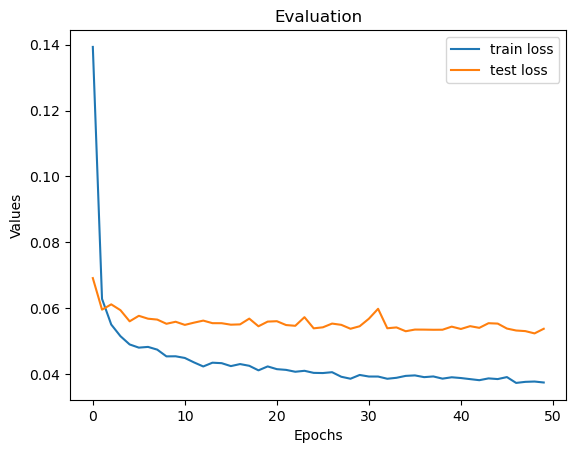

In [24]:
plt.plot([i for i in range(epochs)], train_loss_arr, label='train loss')
plt.plot([i for i in range(epochs)], test_loss_arr, label='test loss')
plt.title('Evaluation')
plt.xlabel('Epochs')
plt.ylabel('Values')
plt.legend();

#### Model seems to be doing alright.
#### Let's see how it does in submission.

## Submission

In [25]:
predictions = []

model.eval() 
with torch.inference_mode():
    for batch, (X,y) in enumerate(test_dataloader_custom):
        X = X.to(device)
        y = y.to(device)
            
        # Forward
        test_pred = model(X)[:,1]
        predictions.append(test_pred.cpu().detach().numpy()[0])

In [26]:
sample['Class'] = predictions
    
sample.to_csv('submission.csv', index=False)
sample

,id,Class
0,117564,0.000049
1,117565,0.000274
2,117566,0.000036
3,117567,0.023935
4,117568,0.009568
...,...,...
78372,195936,0.000122
78373,195937,0.000034
78374,195938,0.000031
78375,195939,0.028882
